In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import joblib

In [3]:
df = pd.read_csv('./data/HCC OP+RFA 20230511 n=2261 去名化.csv')
df.head()
len(df)

2261

In [59]:
df = df.drop(df[df['Treatment'] == 2].index)
df.to_csv('./data/HCC OP 20230511 n=2261 去名化.csv',index=False)
len(df)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


1480

In [4]:
selected_features = [
    'OP&RFA Data ID','ISD number','20230511 OP_NAP','Milan_out', 'Age', 'Sex', 'Image_Vasulcar_invasion(Portal vein,Hepatic vein)', 'BCLC', 'Child_Class'
    , 'Weight', 'Height', 'BMI', 'WBC', 'HB', 'PLAT', 'PTINR', 'ALB', 'Na', 'K', 'CHOL','BUN', 'CR', 'BILI','ALK-P','LDH'
    , 'ALT', 'AST', 'APRI','FIB4', 'NLR','GLU','GGT', 'AFP', 'HBsAg', 'HCV'
    , 'alcoholism', 'Tumor size', 'Tumor number', 'ALBIscore', 'ALBIgrade'
]

selected_labels = ['Recur', 'Recurrence free survival','Early recur','Early RFS','Late recur','Late RFS']

In [5]:
df = pd.read_csv('./data/HCC OP 20230511 n=2261 去名化.csv')
df_op = df[ selected_features+selected_labels ]
df_op.to_csv('./data/HCC OP survival data.csv',index=False)
print(len(df_op))

1480


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


統計每個欄位的缺值
- ISD number 缺 758
- Late recur,Late RFS 缺 652
- 其他都缺不多，最多的為CHOL:147筆

In [11]:
df_op = pd.read_csv('./data/HCC OP survival data.csv')
nan_counts = df_op.isnull().sum()
result_df = pd.DataFrame({'Column': nan_counts.index, 'NaN_Count': nan_counts.values})
print(result_df)

                                               Column  NaN_Count
0                                      OP&RFA Data ID          0
1                                          ISD number        758
2                                           Milan_out          0
3                                                 Age          0
4                                                 Sex          0
5   Image_Vasulcar_invasion(Portal vein,Hepatic vein)          0
6                                                BCLC          0
7                                         Child_Class          0
8                                              Weight         21
9                                              Height         25
10                                                BMI         25
11                                                WBC          0
12                                                 HB          0
13                                               PLAT          0
14                       

In [63]:
df_op_post = pd.read_csv('./data/HCC OP survival data post.csv')
nan_counts = df_op_post.isnull().sum()
result_df = pd.DataFrame({'Column': nan_counts.index, 'NaN_Count': nan_counts.values})
print(result_df)

                                               Column  NaN_Count
0                                      OP&RFA Data ID          0
1                                          ISD number        758
2                                     20230511 OP_NAP        876
3                                           Milan_out          0
4                                                 Age          0
5                                                 Sex          0
6   Image_Vasulcar_invasion(Portal vein,Hepatic vein)          0
7                                                BCLC          0
8                                         Child_Class          0
9                                              Weight         21
10                                             Height         25
11                                                BMI         25
12                                                WBC          0
13                                                 HB          0
14                       

分成三相位齊全跟不齊全的資料集

In [8]:
df = pd.read_csv('./data/HCC OP survival data.csv')
matched_cases = df[df['20230511 OP_NAP'] == 1]['ISD number']

matched_cases_data = df[df['ISD number'].isin(matched_cases)]
matched_cases_data.to_csv('./data/HCC OP 20230511 allNAP.csv',index=False)
print(len(matched_cases),len(matched_cases_data))

604 604


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [9]:
for case in matched_cases:
    df = df.drop(df[df['ISD number'] == case].index)
df.to_csv('./data/HCC OP 20230511 incompleteNAP.csv',index=False)
len(df)

876

統計個案缺值數量
- HCC OP 20230511 allNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']
- HCC OP 20230511 incompleteNAP_v1 是刪除了[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP']

In [25]:
df_NAP = pd.read_csv('./data/HCC OP 20230511 allNAP.csv')
df_NAP = df_NAP.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_NAP.isna().T.sum()
df_NAP['Eachcase Nan count'] = num
df_NAP.to_csv('./data/HCC OP 20230511 allNAP_v1.csv',index=False)


c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [26]:
column_name = 'Eachcase Nan count'
value_counts = df_NAP[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

   Eachcase Nan count  Percentage
0                 494   81.788079
1                  42    6.953642
2                  39    6.456954
3                  17    2.814570
4                   8    1.324503
5                   4    0.662252


In [27]:
df_incomplete = pd.read_csv('./data/HCC OP 20230511 incompleteNAP.csv')
df_incomplete = df_incomplete.drop(columns=[ 'Late recur','Late RFS','ISD number','20230511 OP_NAP'])
num = df_incomplete.isna().T.sum()
df_incomplete['Eachcase Nan count'] = num
df_incomplete.to_csv('./data/HCC OP 20230511 incompleteNAP_v1.csv',index=False)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [28]:
column_name = 'Eachcase Nan count'
value_counts = df_incomplete[column_name].value_counts()
# 計算總資料數
total_count = value_counts.sum()
# 計算各數值佔總資料的百分比
percentages = value_counts / total_count * 100
# 將數值數量和百分比合併為一個DataFrame
result = pd.concat([value_counts, percentages], axis=1, keys=['Eachcase Nan count', 'Percentage'])
# 輸出結果
print(result)

   Eachcase Nan count  Percentage
0                 760   86.757991
1                  41    4.680365
2                  38    4.337900
3                  30    3.424658
4                   4    0.456621
5                   3    0.342466


切資料集

In [29]:
df_NAP = pd.read_csv('./data/HCC OP 20230511 allNAP_v1.csv')
df_incomplete = pd.read_csv('./data/HCC OP 20230511 incompleteNAP_v1.csv')

In [30]:
print(len(df_NAP),len(df_incomplete))

604 876


In [31]:
random_num=20200822
X = df_NAP.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death = df_NAP['Early recur']  # 是否死亡
X_miss = df_incomplete.drop(columns=['Recur', 'Recurrence free survival','Early recur','Early RFS'])
y_death_miss = df_incomplete['Early recur']  # 是否死亡

In [32]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_num)
results = sss.split(X, y_death)
train_index, test_index = results.__next__()
results_miss = sss.split(X_miss, y_death_miss)
train_index_miss, test_index_miss = results_miss.__next__()

In [33]:
print(f"Train: {len(train_index)}")
display(df_NAP.iloc[train_index].Recur.value_counts())
print(f"Test: {len(test_index)}")
display(df_NAP.iloc[test_index].Recur.value_counts())
print(f"Train_miss: {len(train_index_miss)}")
display(df_incomplete.iloc[train_index_miss].Recur.value_counts())
print(f"Test_miss: {len(test_index_miss)}")
display(df_incomplete.iloc[test_index_miss].Recur.value_counts())

Train: 422


1    255
0    167
Name: Recur, dtype: int64

Test: 182


1    112
0     70
Name: Recur, dtype: int64

Train_miss: 613


1    319
0    294
Name: Recur, dtype: int64

Test_miss: 263


1    142
0    121
Name: Recur, dtype: int64

In [34]:
train_df = df_NAP.iloc[train_index]
test_df = df_NAP.iloc[test_index]
train_df_miss = df_incomplete.iloc[train_index_miss]
test_df_miss = df_incomplete.iloc[test_index_miss]

In [35]:
train_df = train_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
train_df_miss = train_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)
test_df_miss = test_df_miss.sample(frac=1, random_state=random_num).sample(frac=1, random_state=random_num).reset_index(drop=True)

In [36]:
train_df.to_csv("./data/HCC OP 20230511 allNAP_v1_train.csv", index=False)
test_df.to_csv("./data/HCC OP 20230511 allNAP_v1_test.csv", index=False)
train_df_miss.to_csv("./data/HCC OP 20230511 incompleteNAP_v1_train.csv", index=False)
test_df_miss.to_csv("./data/HCC OP 20230511 incompleteNAP_v1_test.csv", index=False)

c:\Users\User\anaconda3\envs\OP_RFA\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [37]:
print(len(train_df),len(test_df),len(train_df_miss),len(test_df_miss))

422 182 613 263


HCC OP 20230511 train.csv ,HCC OP 20230511 test.csv是包含recur 跟 early recur兩種

In [39]:
combined_train = pd.concat([train_df, train_df_miss], axis=0)
combined_test = pd.concat([test_df, test_df_miss], axis=0)
combined_train.to_csv('./data/HCC OP 20230511 train.csv',index=False)
combined_test.to_csv('./data/HCC OP 20230511 test.csv',index=False)
print(len(combined_train),len(combined_test))

1035 445


In [ ]:
combined_train = combined_train.drop(columns=['Recur', 'Recurrence free survival'])
combined_test = combined_test.drop(columns=['Recur', 'Recurrence free survival'])
combined_train.to_csv('./data/HCC OP 20230511 train_early.csv',index=False)
combined_test.to_csv('./data/HCC OP 20230511 test_early.csv',index=False)

In [48]:
print(len(combined_train),len(combined_test))

1035 445


看資料分布

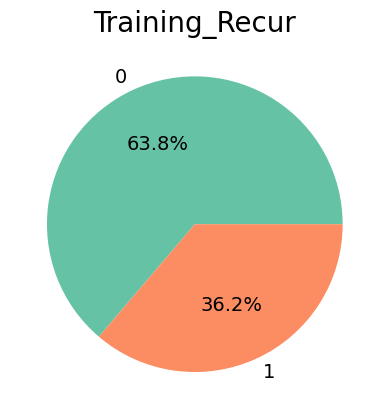

In [49]:
test = pd.read_csv('./data/HCC OP 20230511 train_early.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Training_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
#plt.savefig('./data_cluster/統計圖表/train分佈.png')
plt.show()

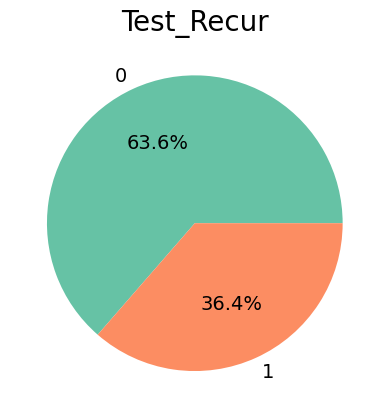

In [3]:
test = pd.read_csv('./data/early/HCC OP 20230511 test_early.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Test_Recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
# plt.savefig('./result/統計圖表/OP_pre test分佈.png')
plt.show()

查看資料集是否有顯著差異

In [51]:
from scipy.stats import ttest_ind
# 計算各欄位的 p-value
p_values = []
for column in combined_train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(combined_train[column], combined_test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(combined_train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

補值

In [54]:
df = pd.read_csv('./data/HCC OP 20230511 train_early.csv')
df = df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)

# 初始化 KNNImputer 物件
imputer = KNNImputer(n_neighbors=200)

# 執行 KNN 補值
df_imputed = imputer.fit_transform(df)

# 將補值後的結果轉換為 DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

# 將補值後的結果加入原始資料集中
df = df_imputed
df.to_csv('./data/HCC OP 20230511 train_early_input.csv',index=False)
print(len(df))

1035


In [55]:
train_df = pd.read_csv("./data/HCC OP 20230511 train_early_input.csv")
test_df = pd.read_csv("./data/HCC OP 20230511 test_early.csv")
test_df = test_df.drop(['OP&RFA Data ID','Eachcase Nan count'], axis=1)
#先將test資料切分出有缺值跟無缺值
known_data = test_df.dropna()
missing_data = test_df[test_df.isna().any(axis=1)]

# 將空字串替換成 NaN 值
#missing_data.replace(' ', np.nan, inplace=True)
missing_data.head()

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,AFP,HBsAg,HCV,alcoholism,Tumor size,Tumor number,ALBIscore,ALBIgrade,Early recur,Early RFS
5,1,63.12,1,0,1,1,60.4,169.3,21.072838,10800,...,17.88,1,0,0.0,14.0,1,-3.356,1.0,1,4.83
7,1,77.10,1,0,2,1,80.7,168.5,28.423249,10500,...,5.84,0,0,0.0,9.0,2,-2.522,2.0,1,14.43
10,0,86.73,1,0,1,1,63.7,159.5,25.039062,2100,...,80.86,1,0,0.0,3.3,1,-2.956,1.0,0,24.00
30,0,41.25,1,0,1,1,78.3,177.6,24.824233,7600,...,11.68,1,0,0.0,3.1,1,-2.978,1.0,1,13.20
38,1,62.76,1,0,1,1,55.9,160.1,21.808668,6100,...,426.00,1,0,0.0,8.0,1,-2.616,1.0,1,22.03


In [56]:
k = 200
imputer = KNNImputer(n_neighbors=k)

for i in range(1,len(missing_data)+1):
    nan_df = missing_data.iloc[i-1:i, :]
    #train_df = pd.concat([train_df,nan_df], ignore_index=True)
    train_df = train_df.append(nan_df)
    
    imputed = imputer.fit_transform(train_df)
    # 進行KNN補值
    df_imputed = pd.DataFrame(imputed, columns=train_df.columns)
    # 提取最後一列資料成為新的 Series 物件
    last_row = df_imputed.iloc[-1,:]
    #known_data = pd.concat([known_data,last_row], ignore_index=True)
    known_data = known_data.append(last_row)
    # 刪除 DataFrame 的最後一列資料
    train_df = train_df.drop(train_df.index[-1])
known_data.to_csv("./data/HCC OP 20230511 test_early_input.csv",index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_5948\177309802.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\User\AppData\Local\Temp\ipykernel_5948\177309802.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\User\AppData\Local\Temp\ipykernel_5948\177309802.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(nan_df)
C:\Users\User\AppData\Local\Temp\ipykernel_5948\177309802.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  known_data = known_data.append(last_row)
C:\Users\User\AppData\Local\Temp\ipykernel_5948\17

增加衍生特徵

In [12]:
df = pd.read_csv('./data/early/HCC OP 20230511 test_early_input.csv')
column = 'PLAT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 120000, 0, np.where(df[column] < 150000, 1, 2))
column = 'PTINR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.1, 1, 0)
column = 'ALB'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 3.5, 0, np.where(df[column] < 3.8, 1, 2))
column = 'CR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1.2, 1, 0)
column = 'BILI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 1.2, 0, np.where(df[column] < 2, 1, 2))
column = 'ALT'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AST'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 40, 0, np.where(df[column] < 80, 1, 2))
column = 'AFP'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 7, 0,
                               np.where(df[column] < 10, 1,
                                        np.where(df[column] < 20, 2,
                                                 np.where(df[column] < 200, 3, 
                                                          np.where(df[column] < 400, 4,5)))))
column = 'Age'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 50, 0,
                               np.where(df[column] < 60, 1,
                                        np.where(df[column] < 65, 2, 3, 
                                                          )))
column = 'BMI'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 23, 0,
                               np.where(df[column] < 25, 1,
                                        np.where(df[column] < 27, 2,
                                                 np.where(df[column] < 27.5, 3, 
                                                          np.where(df[column] < 30, 4,5)))))
column = 'Tumor size'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3, 
                                                          np.where(df[column] < 10, 4,5)))))
column = 'Tumor number'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 1, 1, 0)
column = 'NLR'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] < 2.5, 0,
                               np.where(df[column] < 3, 1,
                                        np.where(df[column] < 4, 2,
                                                 np.where(df[column] < 5, 3,4))))
column = 'FIB4'
new_column_name = 'class_' + column
df[new_column_name] = np.where(df[column] > 3.25, 1, 0)


df.to_csv('./data/early/HCC OP 20230511 test_early_input_derived features.csv',index=False)

In [13]:
df = pd.read_csv('./data/early/HCC OP 20230511 test_early_input_derived features.csv')
columns_to_ln = ['PLAT', 'BUN', 'CR','ALT','AST','AFP','GGT','CHOL','ALK-P', 'LDH','GLU']

# 對指定欄位進行 ln 轉換並存儲為新欄位
for column in columns_to_ln:
    new_column_name = 'ln' + column
    df[new_column_name] = np.log(df[column])

df.to_csv('./data/early/HCC OP 20230511 test_early_input_derived features.csv',index=False)

In [16]:
train = pd.read_csv('./data/early/HCC OP 20230511 train_early_input_derived features.csv')
test = pd.read_csv('./data/early/HCC OP 20230511 test_early_input_derived features.csv')
p_values = []
for column in train.columns:
    # 執行 t 檢定
    _, p_value = ttest_ind(train[column], test[column])
    p_values.append(p_value)

# 打印 p-value
for column, p_value in zip(train.columns, p_values):
    #print(f"{column}: p-value = {p_value}")
    if p_value < 0.05:
        print(column)

正規化

In [18]:
raw_df = pd.read_csv('./data/early/HCC OP 20230511 train_early_input_derived features.csv')
raw_df_test = pd.read_csv('./data/early/HCC OP 20230511 test_early_input_derived features.csv')
display(raw_df.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnBUN,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU
0,0.0,55.95,1.0,0.0,1.0,1.0,70.4,166.5,25.394764,4400.0,...,2.708050,0.307485,3.891820,3.555348,1.766442,4.465908,5.093750,4.248495,5.752573,4.948760
1,1.0,64.11,1.0,1.0,3.0,1.0,47.9,173.4,15.930791,5100.0,...,2.302585,-0.301105,3.135494,3.526361,5.780744,4.521789,5.147494,4.382027,5.501258,4.454347
2,1.0,48.93,1.0,0.0,1.0,1.0,85.5,170.4,29.446042,8900.0,...,2.944439,-0.051293,3.258097,3.465736,4.520375,3.610918,5.365976,4.369448,5.456645,4.574711
3,0.0,66.67,2.0,0.0,1.0,1.0,43.6,146.7,20.259385,4700.0,...,2.639057,-0.385662,3.258097,3.433987,1.383791,3.258097,5.293305,4.317488,5.351858,4.736198
4,0.0,47.24,2.0,0.0,1.0,1.0,44.9,157.0,18.215749,4900.0,...,4.219508,2.184927,3.218876,3.828641,4.770685,3.496508,5.278115,4.499810,5.929589,4.204693


In [19]:
X_train = raw_df.drop(columns=['Early recur','Early RFS'])
y_train = raw_df[['Early recur','Early RFS']]
X_test = raw_df_test.drop(columns=['Early recur','Early RFS'])
y_test = raw_df_test[['Early recur','Early RFS']]

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
display(scaled_X_train.tail())
display(y_train.tail())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnBUN,lnCR,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU
1030,-0.839707,0.672319,-0.541987,-0.234619,-1.637194,-0.112784,-0.324485,-0.761871,0.130029,0.717070,...,-0.882297,0.591712,-0.765823,-1.197137,-0.778680,-1.348168,0.050245,-0.832577,0.696133,0.228922
1031,-0.839707,-0.871032,1.845062,-0.234619,-0.141611,-0.112784,-0.973151,-0.811753,-0.679637,-0.282153,...,-0.409391,-0.770694,0.277531,0.020281,0.737326,-0.184003,-0.571374,0.373724,2.344974,0.077270
1032,-0.839707,0.937964,1.845062,-0.234619,-0.141611,-0.112784,-1.246273,-0.300465,-1.322623,-1.231414,...,-0.409391,-0.851671,0.309903,0.224494,-0.890320,1.079346,-1.478030,-1.498519,-0.871508,0.231026
1033,1.190892,0.456380,-0.541987,-0.234619,-0.141611,-0.112784,0.255900,0.634817,-0.098657,1.216682,...,0.178406,0.225682,-0.765823,-1.385433,-1.049337,-0.775531,-1.635049,-1.188382,-1.293822,0.319989
1034,-0.839707,-0.698281,-0.541987,-0.234619,-0.141611,-0.112784,0.102269,-0.662108,0.607965,0.067575,...,-0.635980,-0.294832,0.930863,0.104944,-0.877596,1.011008,-0.120202,0.121290,-0.155773,0.435032


,Early recur,Early RFS
1030,0.0,24.0
1031,0.0,24.0
1032,0.0,24.0
1033,0.0,24.0
1034,0.0,24.0


In [21]:
scaled_data = pd.concat([scaled_X_train, y_train], axis=1)
scaled_data_test = pd.concat([scaled_X_test, y_test], axis=1)
scaled_data.to_csv('./data/early/HCC OP 20230511 train_early_input_derived features_std.csv',index=False)
scaled_data_test.to_csv('./data/early/HCC OP 20230511 test_early_input_derived features_std.csv',index=False)
joblib.dump(scaler, './data/early/HCC OP 20230511 train_early_input_derived features_scaler.bin')

['./data/early/HCC OP 20230511 train_early_input_derived features_scaler.bin']

確認分布

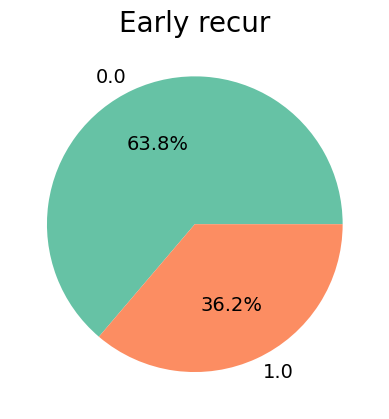

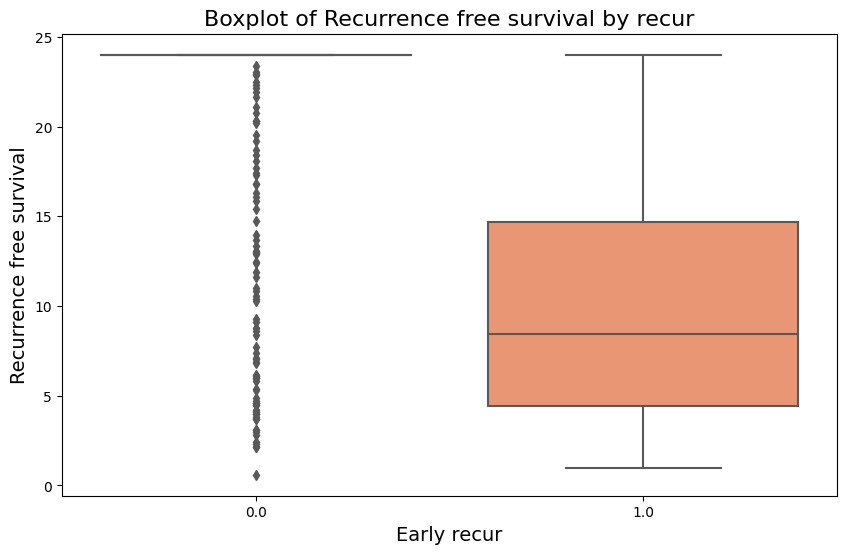

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/early/HCC OP 20230511 train_early_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Early recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Early recurrence free survival']和train['Early recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Early recur"], y=test["Early RFS"], palette=sns.color_palette("Set2"))
plt.xlabel('Early recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()

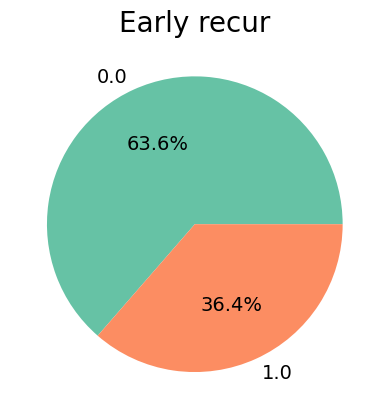

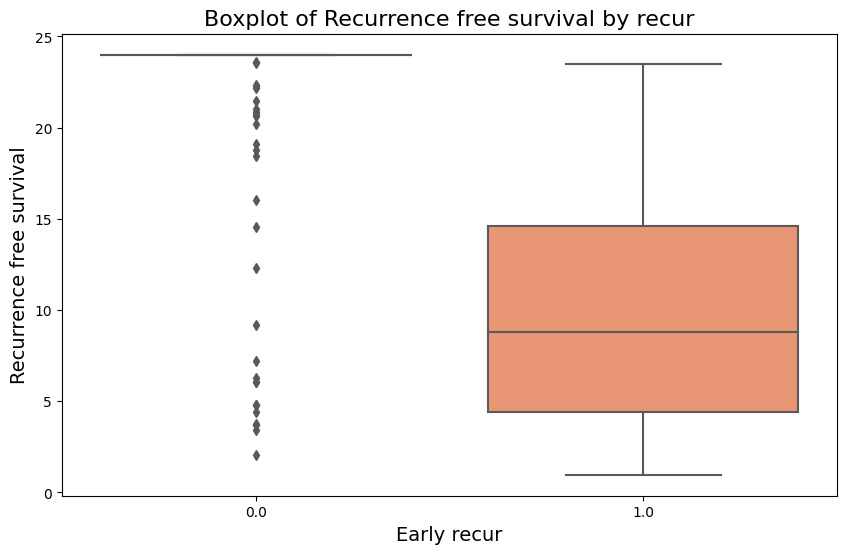

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
test = pd.read_csv('./data/early/HCC OP 20230511 test_early_input_derived features_std.csv')
# 绘制train['recur']的圆饼图
counts = test['Early recur'].value_counts().to_dict()
counts_keys = list(counts.keys())
counts_keys.sort()
counts = {k: counts[k] for k in counts_keys}
fig, ax = plt.subplots()
colors = sns.color_palette("Set2")[:len(counts.keys())]
ax.set_title('Early recur', fontdict={'size': 20})
ax.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

# 绘制train['Early recurrence free survival']和train['Early recur']的箱线图
plt.figure(figsize=(10, 6))  # 设置图形的大小（可选）
sns.boxplot(x=test["Early recur"], y=test["Early RFS"], palette=sns.color_palette("Set2"))
plt.xlabel('Early recur', fontsize=14)  # 设置x轴标签
plt.ylabel('Recurrence free survival', fontsize=14)  # 设置y轴标签
plt.title('Boxplot of Recurrence free survival by recur', fontsize=16)  # 设置图形标题
plt.show()

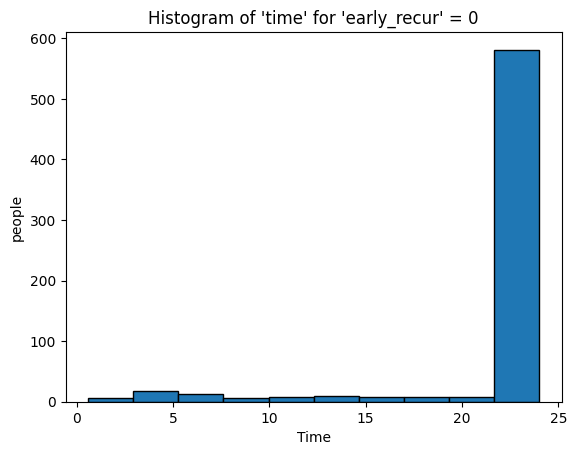

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
test = pd.read_csv('./data/early/HCC OP 20230511 train_early_input_derived features_std.csv')
filtered_data = test[test['Early recur'] == 0]

# 提取 'time' 欄位數值
time_values = filtered_data['Early RFS']

# 繪製直方圖
plt.hist(time_values, bins=10, edgecolor='black')

# 設定圖表標籤和標題
plt.xlabel('Time')
plt.ylabel('people')
plt.title("Histogram of 'time' for 'early_recur' = 0")

# 顯示圖表
plt.show()
